<a href="https://colab.research.google.com/github/luisovillista/LEO/blob/main/ENE_DIC_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analisis 24


In [39]:
# -----------------------------------------
# pip install pandas matplotlib geopandas folium geopy plotly==5

In [40]:

# =========================================
# 1. Imports & setup
# -----------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
import time

plt.rcParams["figure.dpi"] = 120

CSV_URL = (
    "https://raw.githubusercontent.com/luisovillista/LEO/refs/heads/main/ENE_DIC_24.csv"
)


In [41]:
# =========================================
# 2. Carga + limpieza express
# -----------------------------------------
df = pd.read_csv(CSV_URL)

def clean_text(s):
    return s.strip().title().replace("Ñ", "N") if isinstance(s, str) else s

df["Municipality"]  = df["Municipality"].apply(clean_text)
df["Establishment"] = df["Establishment"].apply(clean_text)
df = df.drop_duplicates(subset=["License Number"])

money_cols = [
    "Amount Played", "Amount Won", "Net Wager", "Funds In", "Funds Out",
    "Net Terminal Income", "NTI Tax", "State Share", "Municipality Share"
]
df[money_cols] = df[money_cols].apply(pd.to_numeric, errors="coerce")

df["NTI_per_VGT"]      = df["Net Terminal Income"] / df["VGT Count"]
df["Return_to_Player"] = df["Amount Won"] / df["Amount Played"]

agg = (
    df.groupby("Municipality")
      .agg(
          VGTs_total        = ("VGT Count", "sum"),
          NTI_total         = ("Net Terminal Income", "sum"),
          NTI_prom_por_VGT  = ("NTI_per_VGT", "mean"),
          Retorno_promedio  = ("Return_to_Player", "mean")
      )
      .reset_index()
      .sort_values("NTI_total", ascending=False)
)


	📊 Análisis Exploratorio - Gráficos Estáticos

Conjunto de visualizaciones básicas (barras, dispersión y distribución) que permite identificar rápidamente
a) los condados con mayor ingreso neto (NTI),
b) la relación entre número de máquinas y recaudación, y
c) la variabilidad en el retorno al jugador. Es el primer filtro para detectar focos de oportunidad o saturación.

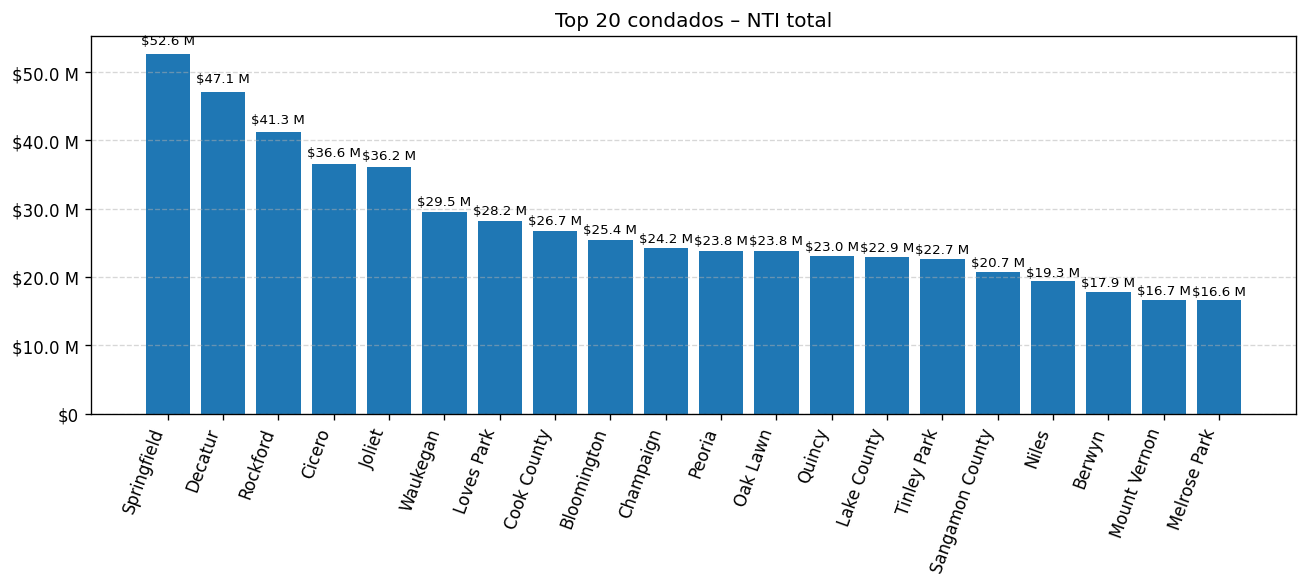

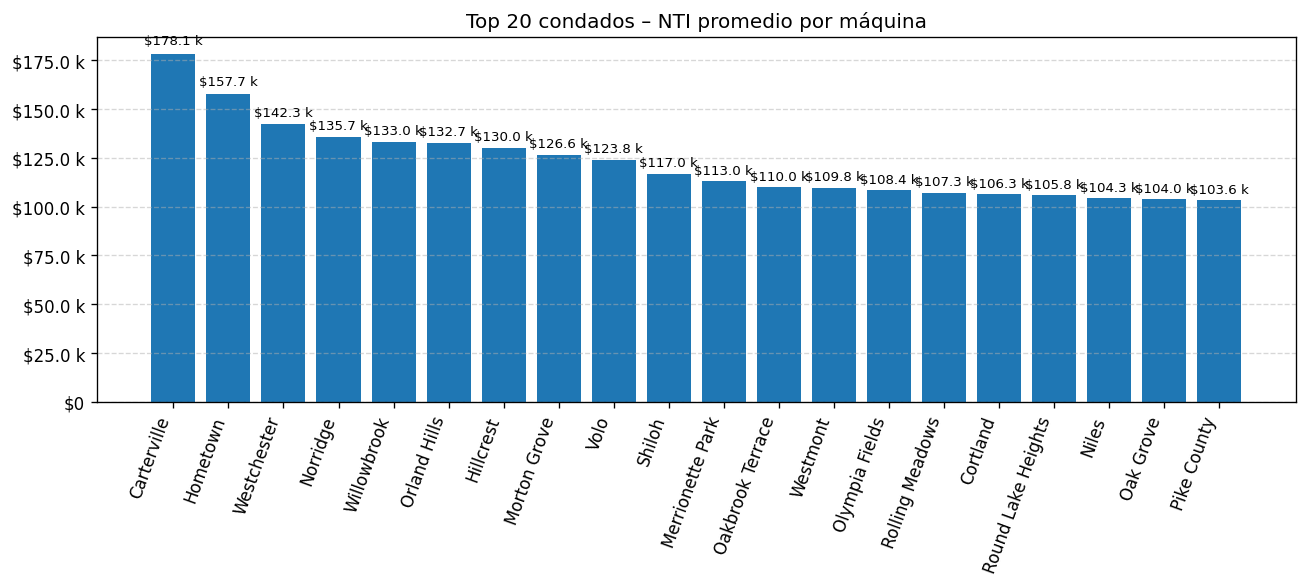

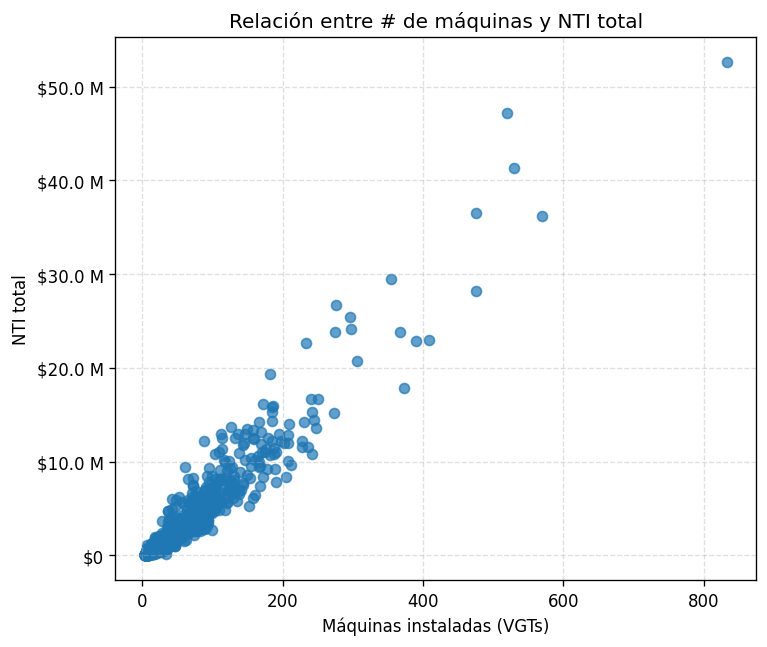

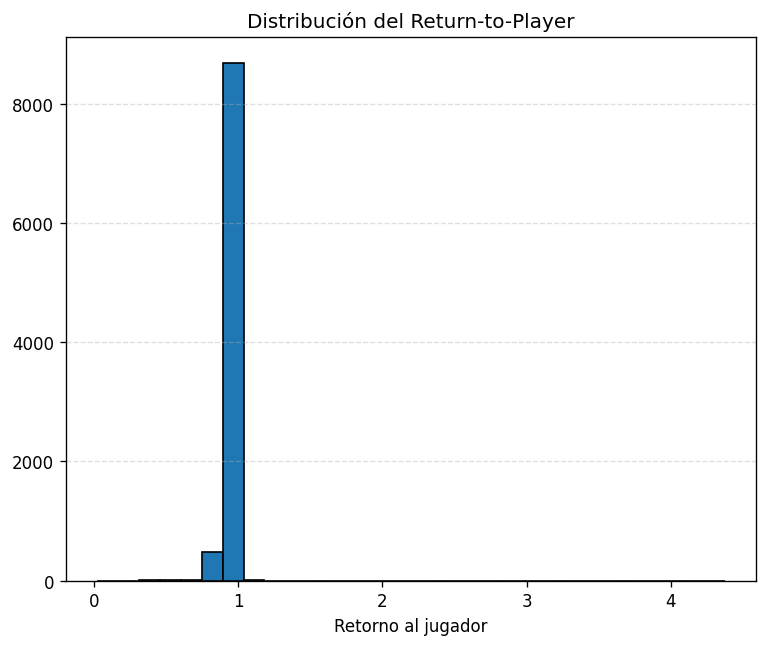

In [42]:
# -----------------------------------------
# 3. Gráficos estáticos rápidos (Matplotlib) – versión pro v2
# -----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

# ───────── Helpers ────────────────────────────────────────────
def human_fmt(x, pos=None):
    """
    Convierte números a texto abreviado:
    1 234 567 -> $1.2 M
    45 678    -> $45.7 k
    """
    if x >= 1_000_000:
        return f'${x/1_000_000:.1f} M'
    elif x >= 1_000:
        return f'${x/1_000:.1f} k'
    else:
        return f'${x:.0f}'

money_short = FuncFormatter(human_fmt)
money_full  = mtick.StrMethodFormatter('${x:,.0f}')

# ── A) Top-20 NTI total por condado ──────────────────────────
top_total = agg.head(20)

plt.figure(figsize=(11, 5))
bars = plt.bar(top_total["Municipality"], top_total["NTI_total"])

# Eje Y abreviado (k / M)
plt.gca().yaxis.set_major_formatter(money_short)
plt.xticks(rotation=70, ha='right')
plt.title("Top 20 condados – NTI total")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Etiquetas encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height * 1.02,
             human_fmt(height),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ── B) Top-20 NTI promedio por máquina ───────────────────────
top_vgt = agg.sort_values("NTI_prom_por_VGT", ascending=False).head(20)

plt.figure(figsize=(11, 5))
bars = plt.bar(top_vgt["Municipality"], top_vgt["NTI_prom_por_VGT"])

plt.gca().yaxis.set_major_formatter(money_short)
plt.xticks(rotation=70, ha='right')
plt.title("Top 20 condados – NTI promedio por máquina")
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height * 1.02,
             human_fmt(height),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ── C) Dispersión – VGTs vs NTI total ────────────────────────
plt.figure(figsize=(6.5, 5.5))
plt.scatter(agg["VGTs_total"], agg["NTI_total"], alpha=0.7)
plt.gca().yaxis.set_major_formatter(money_short)
plt.xlabel("Máquinas instaladas (VGTs)")
plt.ylabel("NTI total")
plt.title("Relación entre # de máquinas y NTI total")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ── D) Histograma del Return-to-Player ───────────────────────
rtp_clean = (
    df["Return_to_Player"]
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
)
plt.figure(figsize=(6.5, 5.5))
plt.hist(rtp_clean, bins=30, edgecolor='black')
plt.xlabel("Retorno al jugador")
plt.title("Distribución del Return-to-Player")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



✨ Analítica Interactiva - Plotly

Burbujas y treemap dinámicos que facilitan el “drill-down” sobre cada condado: las burbujas muestran volumen (NTI total) y eficiencia (NTI por máquina) en un mismo plano; el treemap revela la participación relativa de cada condado dentro del portafolio global.


In [43]:
# -----------------------------------------
# 4. Gráficos interactivos (Plotly)
# -----------------------------------------
# a) SOLO usamos registros con NTI_prom_por_VGT positivo
plot_df = agg[agg["NTI_prom_por_VGT"] > 0].copy()

fig = px.scatter(
    plot_df,
    x="VGTs_total",
    y="NTI_total",
    size="NTI_prom_por_VGT",
    hover_name="Municipality",
    size_max=40,                          # escala máxima del marcador
    title="Burbuja: VGTs vs NTI total (tamaño = NTI/ máquina)"
)
fig.show()

fig = px.treemap(
    plot_df,
    path=["Municipality"],
    values="NTI_total",
    title="Treemap – distribución de NTI total por municipio"
)
fig.show()


	🗺️ Choropleth Rendimiento Verde-Amarillo-Rojo

Mapa temático de EE. UU. en el que cada condado se colorea según su NTI: verde intenso indica alto rendimiento, amarillo desempeño medio y rojo baja rentabilidad. Incluye leyenda continua y tooltips con el valor exacto, lo que permite evaluar la competitividad geográfica de un vistazo.

In [44]:
# =========================================================
# 5. Choropleth – Verde = mejor, Rojo = peor
# =========================================================
from IPython.display import display
import branca.colormap as bcm

try:
    COUNTY_GEO = (
        "https://raw.githubusercontent.com/"
        "python-visualization/folium/main/tests/us-counties.json"
    )
    counties = gpd.read_file(COUNTY_GEO)

    # Limpia nombres: quita “County”, pasa a Title Case
    agg["County_clean"] = (
        agg["Municipality"]
          .str.replace(r"\s+County$", "", regex=True)
          .str.title()
    )

    # (opcional) filtra un solo estado por FIPS
    # counties = counties[counties["id"].str.startswith("17")]  # Illinois

    map_df = counties.merge(
        agg, left_on="name", right_on="County_clean", how="left"
    )

    # ===== colormap RdYlGn (rojo→amarillo→verde) ===========
    min_val = map_df["NTI_total"].min()
    max_val = map_df["NTI_total"].max()
    colormap = bcm.linear.RdYlGn_09.scale(min_val, max_val)
    colormap.caption = "NTI total por condado (USD)"

    # ===== crea el mapa =====================================
    m = folium.Map(location=[39.8, -98], zoom_start=4)
    colormap.add_to(m)  # leyenda

    def style_fn(feature):
        name = feature["properties"]["name"]
        value = map_df.loc[map_df["name"] == name, "NTI_total"].values
        color = colormap(value[0]) if len(value) and pd.notnull(value[0]) else "#cccccc"
        return {
            "fillOpacity": 0.7,
            "weight": 0.2,
            "fillColor": color,
            "color": "black"
        }

    folium.GeoJson(
        map_df,
        name="NTI_por_condado",
        style_function=style_fn,
        tooltip=folium.features.GeoJsonTooltip(
            fields=["name", "NTI_total"],
            aliases=["Condado", "NTI total"],
            localize=True,
            sticky=False
        ),
    ).add_to(m)

    m.save("choropleth_US_NTI.html")
    print("🔥 Choropleth guardado como choropleth_US_NTI.html")

    display(m)  # incrusta en el notebook
except Exception as e:
    print("No se generó choropleth:", e)


🔥 Choropleth guardado como choropleth_US_NTI.html


🔵 Mapa de Burbujas con Gradiente de Color

Visualización geoespacial que superpone burbujas sobre el centroide de cada condado. El radio refleja el NTI total (volumen de mercado) y el color sigue la misma escala verde-amarillo-rojo del choropleth (calidad del ingreso).


In [45]:
# =========================================================
# 6. Mapa de burbujas rápido (RdYlGn: verde = top, rojo = flop)
# =========================================================
from IPython.display import display
import branca.colormap as bcm

try:
    # Re-usa map_df del choropleth (geometría + NTI_total)
    bubble_df = map_df.dropna(subset=["NTI_total"]).copy()
    bubble_df["lon"] = bubble_df.geometry.centroid.x
    bubble_df["lat"] = bubble_df.geometry.centroid.y

    # Colormap RdYlGn (rojo→amarillo→verde)
    min_val = bubble_df["NTI_total"].min()
    max_val = bubble_df["NTI_total"].max()
    colormap = bcm.linear.RdYlGn_09.scale(min_val, max_val)
    colormap.caption = "NTI total por condado (USD)"

    bmap = folium.Map(location=[39.8, -98], zoom_start=4)
    colormap.add_to(bmap)  # añade leyenda

    for _, row in bubble_df.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=max(row["NTI_total"] / 1e6, 3),           # tamaño según NTI
            color=colormap(row["NTI_total"]),                # borde
            fill=True,
            fill_color=colormap(row["NTI_total"]),           # relleno por NTI
            fill_opacity=0.75,
            popup=f"{row['name']} County:<br>${row['NTI_total']:,.0f}"
        ).add_to(bmap)

    bmap.save("burbujas_NTI.html")
    print("✅ Mapa burbujas guardado como burbujas_NTI.html")

    display(bmap)   # incrusta en el cuaderno
except Exception as e:
    print("No se generó el mapa de burbujas:", e)


/tmp/ipython-input-45-1264279984.py:10: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-45-1264279984.py:11: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




✅ Mapa burbujas guardado como burbujas_NTI.html


In [46]:
# =========================================================
# 7. Exporta tablas y muestra resumen
# =========================================================
from IPython.display import display
import os

# --- 7-A  Guarda todo en un solo Excel --------------------
OUT_XLSX = "resumen_municipios.xlsx"
with pd.ExcelWriter(OUT_XLSX) as writer:
    # Hoja 1: todos los condados con métricas
    agg.to_excel(writer, sheet_name="Resumen_Completo", index=False)

    # Hoja 2: Top 20 en NTI total
    agg.sort_values("NTI_total", ascending=False).head(20)\
       .to_excel(writer, sheet_name="Top20_NTI_total", index=False)

    # Hoja 3: Top 20 en NTI por máquina
    agg.sort_values("NTI_prom_por_VGT", ascending=False).head(20)\
       .to_excel(writer, sheet_name="Top20_NTIxVGT", index=False)

print(f"💾 Excel exportado: {OUT_XLSX}  ({os.path.getsize(OUT_XLSX)/1024:.1f} KB)")

# --- 7-B  Copia ligera a CSV (por si acaso) ---------------
agg.to_csv("resumen_municipios.csv", index=False)

# --- 7-C  Vista previa en el cuaderno ---------------------
print("🔍 Top 10 condados por NTI total")
display(
    agg.sort_values("NTI_total", ascending=False).head(10)
          .style.format({"NTI_total":"${:,.0f}",
                         "NTI_prom_por_VGT":"${:,.0f}",
                         "Retorno_promedio":"{:.2%}"})
)



💾 Excel exportado: resumen_municipios.xlsx  (66.7 KB)
🔍 Top 10 condados por NTI total
